In [2]:
import urllib
import zipfile
import os
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
import numpy as np

import matplotlib.pyplot as plt
from utils import ctshow

In [3]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
data_dir = Path('../data/')
data_dir.mkdir(exist_ok=True, parents=True)
if not data_dir.exists():
  urllib.request.urlretrieve('https://docs.google.com/uc?export=download&id=1-ZqL_1cqWeG6LsRAB0TwiddW8TgQ-q70', data_dir/'Denoising_Data.zip')
  with zipfile.ZipFile(data_dir / 'Denoising_Data.zip', 'r') as zip_ref:
     zip_ref.extractall(data_dir)

In [5]:
# load training data, used to update CNN weights
# 2000 30x30 image patches from 8 patients
train_input = np.load(data_dir/'Denoising_Data/train_input.npy')
train_target = np.load(data_dir/'Denoising_Data/train_target.npy')
# load validation data, used to monitor for overfitting
# 1000 30x30 image patches from 1 patient
val_input = np.load(data_dir/'Denoising_Data/val_input.npy')
val_target = np.load(data_dir/'Denoising_Data/val_target.npy')

# load testing data, used for evaluating performance
# 5 512x512 images from 1 patient
test_input = np.load(data_dir/'Denoising_Data/test_input.npy')
test_target = np.load(data_dir/'Denoising_Data/test_target.npy')

# Load examples images from state-of-the-art CNN denoising for CT images
test_example = np.load(data_dir/'Denoising_Data/test_input_denoised.npy')

print('Data loading completed.')

Data loading completed.


In [7]:
n_layers = 6
filters = 64
kernel_size = (3, 3)
strides = (1, 1)
activation = 'relu'

def build_model():
    xin = keras.layers.Input(shape=(None, None, 1), name='input_CT_images')
    # We define a preprocessing layer to rescale the CT image pixel values
    shift_mean = train_input.mean()
    rescale = train_input.std()
    x = keras.layers.Lambda(
        lambda x: (x - shift_mean) / rescale,
        name='normalization')(xin)

    for i in range(n_layers - 1):
        x = keras.layers.Conv2D(
          filters=filters,
          kernel_size=kernel_size,
          strides=strides,
          padding='same')(x)
        x = keras.layers.Activation(activation)(x)
    # Final layer has just one feature map corresponding to the output image
    x = keras.layers.Conv2D(
        filters=1,
        kernel_size=kernel_size,
        strides=strides,
        padding='same')(x)
    # Here we rescale the output to typical CT number range
    xout = keras.layers.Lambda(
        lambda x: (x * rescale) + shift_mean,
        name='output_CT_images')(x)
    # We define the model by specifying the inputand output tensors
    model = keras.Model(inputs=xin, outputs=xout, name="CT_denoiser")
    return model

In [10]:
noise_patch_dir = Path('../noise_patches')
diameters = [112, 131, 151, 185, 200, 216, 292, 350]
# diameters = [151]
# diameters = [112, 131]

# noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
# noise_patch_dict = {f.stem: np.load(f) for f in noise_files}
# noise_patches = np.concatenate(list(noise_patch_dict.values()))
# noise_patches = np.zeros_like(noise_patches)

In [11]:
def load_noise_patch_dict(diameters = [112, 131, 151, 185, 216, 292, 350]):
    noise_files = [noise_patch_dir / f'diameter{d}mm.npy' for d in diameters]
    return {f.stem: np.load(f) for f in noise_files}
    
def load_noise_patches(diameters=[112, 131, 151, 185, 216, 292, 350]):
    noise_patch_dict = load_noise_patch_dict(diameters)
    return np.concatenate(list(noise_patch_dict.values()))

In [12]:
import sys
sys.path.append('..')
from nps_utils import compute_nps

In [13]:
example_input = test_input[[3], ...]
edge_buffer = 128
progress_ims = []
progress_val = []

class SaveSampleImageCallback(keras.callbacks.Callback):
    def __init__(self, progress_ims, progress_val):
          super().__init__()
          self.progress_ims = progress_ims
          self.progress_val = progress_val
    def on_epoch_begin(self, epoch, logs=None):
            val_loss = self.model.evaluate(val_input, val_target)
            example_output = self.model.predict(example_input)
            example_img = example_output[0, edge_buffer:-edge_buffer,
                                         edge_buffer:-edge_buffer, 0]
            self.progress_ims.append(example_img)
            self.progress_val.append(val_loss)

In [14]:
def denoising_size_dependence(model, noise_patch_dict, N=None):
    N = N or len(noise_patch_dict['diameter112mm'])
    return {name: 100*(model.predict(patch_set[:N,:,:,None]).std()-patch_set[:N,:,:,None].std())/patch_set[:N,:,:,None].std() for name, patch_set in noise_patch_dict.items()}
noise_patch_dict = load_noise_patch_dict(diameters = [112, 131, 151, 185, 216, 292, 350])

In [16]:
noise_patch_dict.keys()

dict_keys(['diameter112mm', 'diameter131mm', 'diameter151mm', 'diameter185mm', 'diameter216mm', 'diameter292mm', 'diameter350mm'])

In [15]:
noise_patch_dict['diameter131mm'][:,:,:,None].shape

(60000, 30, 30, 1)

In [17]:
val_input = noise_patch_dict['diameter131mm'][:1000,:,:,None]
val_target = np.zeros_like(val_input)
val_input.shape, val_target.shape

((1000, 30, 30, 1), (1000, 30, 30, 1))

In [19]:
import datetime
from tensorflow.keras.metrics import RootMeanSquaredError
from functools import partial

rng = tf.random.Generator.from_seed(123, alg='philox')


# This sets the number of iterations through the training data
epochs = 15
batch_size = 32
learning_rate = 0.0001
SHUFFLE_BUFFER_SIZE = 1000
# optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer = 'adam'

train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

AUTOTUNE = tf.data.AUTOTUNE

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

def train(augment_training=0.7, model=None, epochs=15, noise_textures=[112, 131, 151, 185, 216, 292]):
    'providing `model` as an argument skips model building and compiling and allows fine-tuning with a pretrained model'
  
    noise_patches = load_noise_patches(diameters=noise_textures)
    
    def augment(image_label, seed, aug_thresh = 0.7, max_noise=1):
      'aug_thresh = lambda the frequency of augmentation, 0 = None, 1 = All'
      image, label = image_label
      new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
      noise_patch = noise_patches[np.random.choice(list(range(len(noise_patches))))][:,:,None]
      noise_lambda = tf.random.uniform([1], minval=0, maxval=max_noise)[0]
      add_noise = tf.random.uniform([1], minval=0, maxval=1) < aug_thresh #from 0.5

      if add_noise:
        image = label + noise_lambda*noise_patch
      return image, label

    def f(x, y):
      seed = rng.make_seeds(2)[0]
      image, label = augment((x, y), seed, aug_thresh = augment_training)
      return image, label

    train_ds = (
      train_dataset
      .map(f, num_parallel_calls=AUTOTUNE)
      .prefetch(AUTOTUNE)
    )

    if model is None:
        model = build_model()
        model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
    progress_ims = []
    progress_val = []
    callback = SaveSampleImageCallback(progress_ims, progress_val)
    model.fit(train_ds, epochs = epochs, callbacks=[callback, tensorboard_callback], validation_data=val_dataset)

    progress_ims = np.stack(progress_ims, axis=0)

    print('Training phase complete.')
    return model, np.stack(callback.progress_ims, axis=0), callback.progress_val

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

base_denoising_model, base_progress_ims, base_progress_val = train(augment_training=0, epochs=15)

1/1 [==============================] - 0s 101ms/step
Epoch 1/15
1/1 [==============================] - 0s 61ms/step
Epoch 2/15
1/1 [==============================] - 0s 60ms/step
Epoch 3/15
1/1 [==============================] - 0s 56ms/step
Epoch 4/15
1/1 [==============================] - 0s 61ms/step
Epoch 5/15
1/1 [==============================] - 0s 65ms/step
Epoch 6/15
1/1 [==============================] - 0s 60ms/step
Epoch 7/15
1/1 [==============================] - 0s 60ms/step
Epoch 8/15
1/1 [==============================] - 0s 60ms/step
Epoch 9/15
1/1 [==============================] - 0s 61ms/step
Epoch 10/15
1/1 [==============================] - 0s 66ms/step
Epoch 11/15
1/1 [==============================] - 0s 63ms/step
Epoch 12/15
1/1 [==============================] - 0s 62ms/step
Epoch 13/15
1/1 [==============================] - 0s 66ms/step
Epoch 14/15
1/1 [==============================] - 0s 64ms/step
Epoch 15/15
71/71 [==============================] - 8s 106m

In [21]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


In [22]:
def check_progress_ims(progress_ims):
    plt.figure(figsize=(12, 12))

    plt.subplot(2, 2, 1)
    plt.title('Before Optimization', fontsize=16)
    ctshow(progress_ims[0, :, :], window='variable')

    plt.subplot(2, 2, 2)
    plt.title('Epoch %d/%d' %(1, epochs), fontsize=16)
    ctshow(progress_ims[1, :, :], window='soft_tissue')

    plt.subplot(2, 2, 3)
    plt.title('Epoch %d/%d' %(5, epochs), fontsize=16)
    ctshow(progress_ims[5, :, :], window='soft_tissue')

    plt.subplot(2, 2, 4)
    plt.title('Final Epoch', fontsize=16)
    ctshow(progress_ims[-1, :, :], window='soft_tissue')

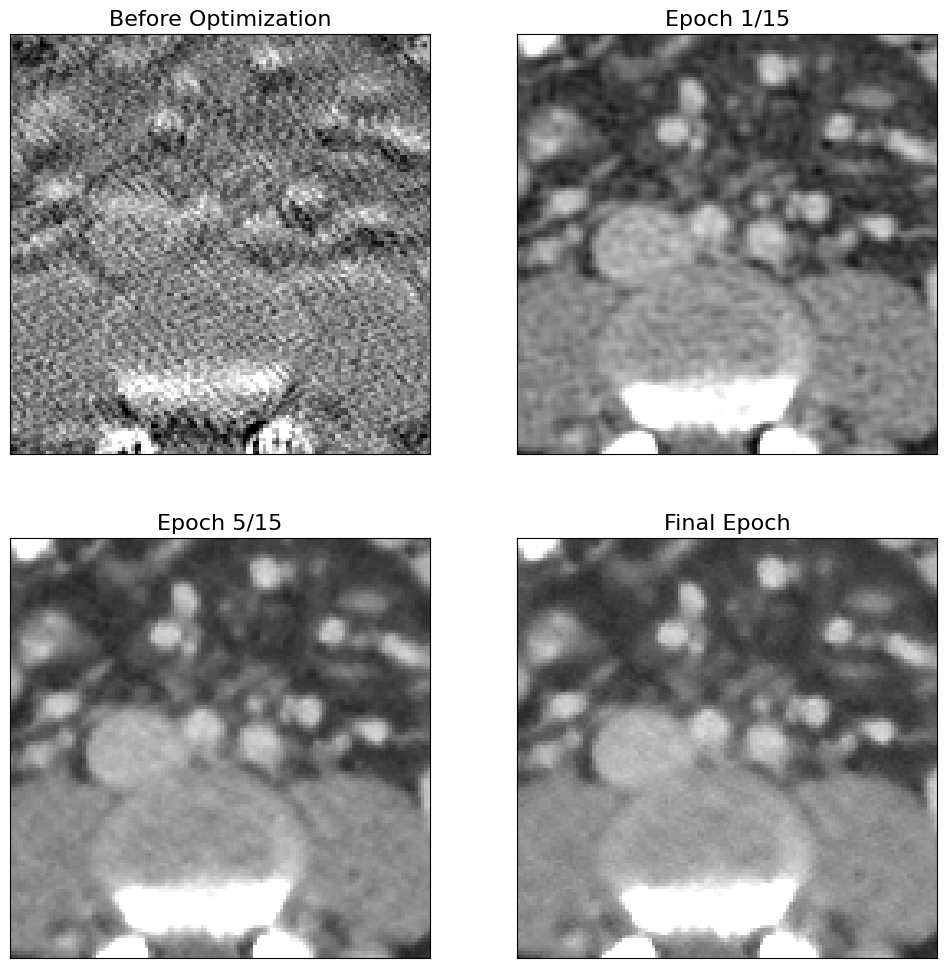

In [23]:
check_progress_ims(base_progress_ims)

## Now with augmentation

In [37]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_input, train_target))
val_dataset = tf.data.Dataset.from_tensor_slices((val_input, val_target))
test_dataset = tf.data.Dataset.from_tensor_slices((test_input, test_target))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

aug_denoising_model, aug_progress_ims, aug_progress_val = train(augment_training=0.65, epochs=25)

29/32 [==========================>...] - ETA: 0s - loss: 227202.3594 - root_mean_squared_error: 476.6575

1/1 [==============================] - 0s 88ms/step
Epoch 1/25
1/1 [==============================] - 0s 61ms/step
Epoch 2/25
1/1 [==============================] - 0s 59ms/step
Epoch 3/25
1/1 [==============================] - 0s 54ms/step
Epoch 4/25
1/1 [==============================] - 0s 60ms/step
Epoch 5/25
1/1 [==============================] - 0s 61ms/step
Epoch 6/25
1/1 [==============================] - 0s 62ms/step
Epoch 7/25
1/1 [==============================] - 0s 65ms/step
Epoch 8/25
1/1 [==============================] - 0s 64ms/step
Epoch 9/25
1/1 [==============================] - 0s 66ms/step
Epoch 10/25
1/1 [==============================] - 0s 61ms/step
Epoch 11/25
1/1 [==============================] - 0s 62ms/step
Epoch 12/25
1/1 [==============================] - 0s 66ms/step
Epoch 13/25
1/1 [==============================] - 0s 56ms/step
Epoch 14/25
1/1 [==============================] - 0s 60ms/step
Epoch 15/25
1/1 [==============================] - 0s 63ms/st

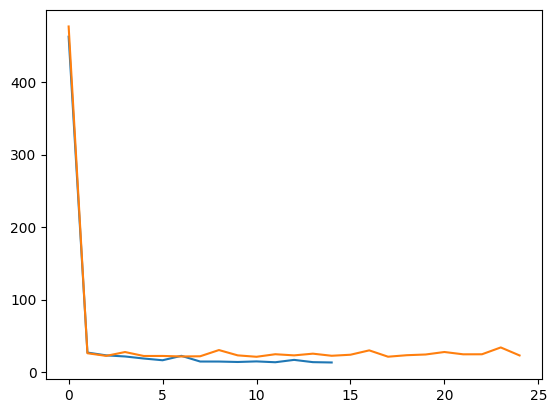

In [38]:
plt.plot(np.array(base_progress_val)[:, 1],label='cnn')
plt.plot(np.array(aug_progress_val)[:, 1],label='aug')
plt.show()

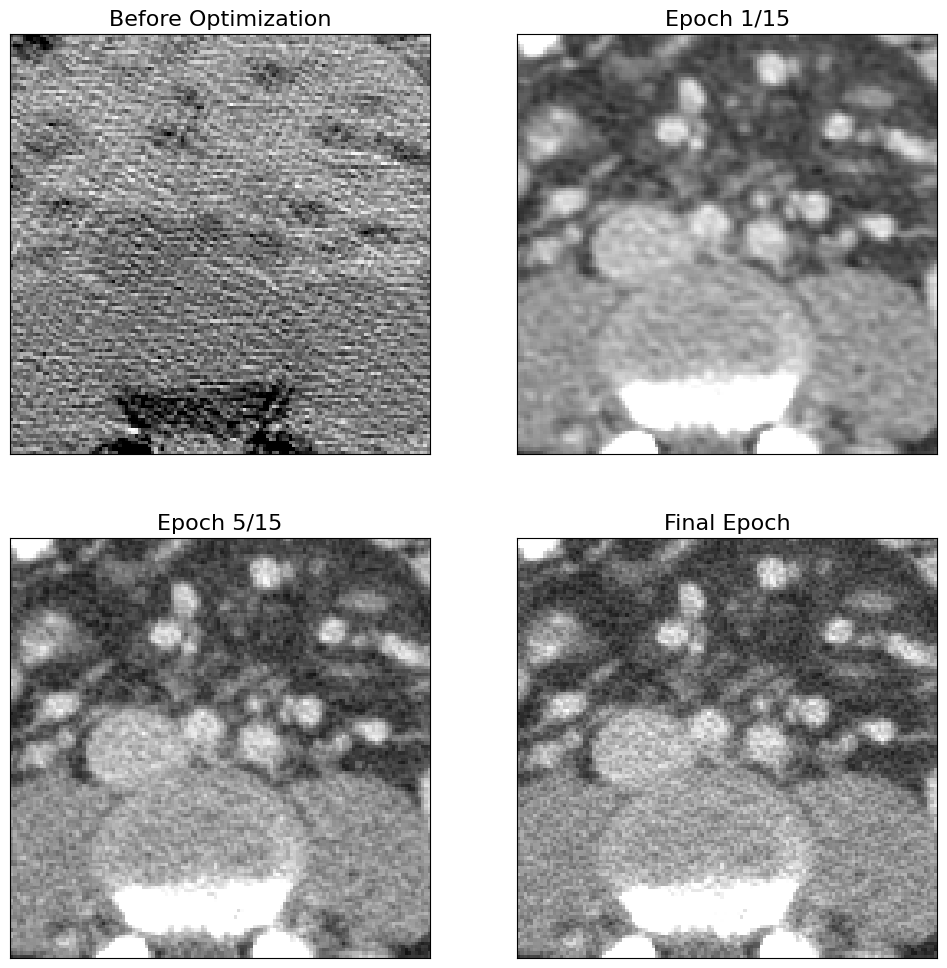

In [39]:
check_progress_ims(aug_progress_ims)

7/7 [==============================] - 1s 77ms/step


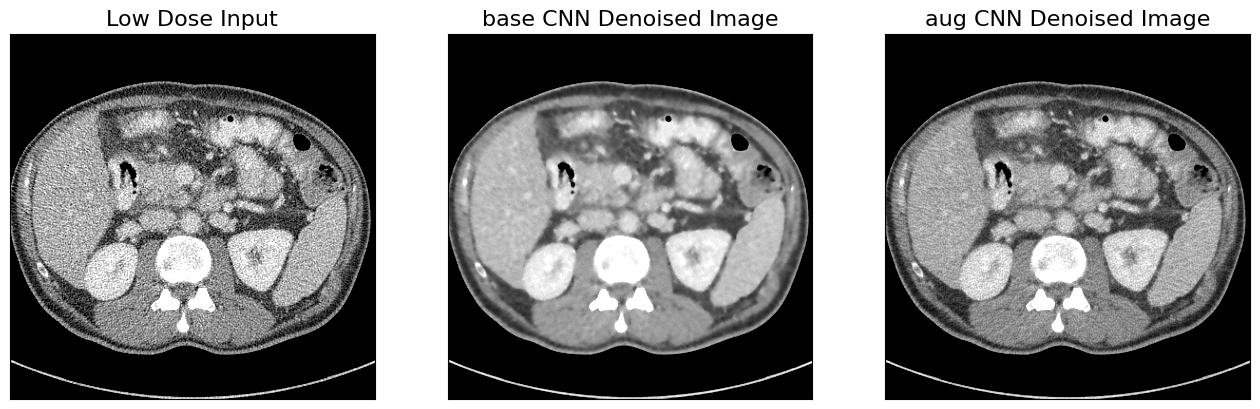

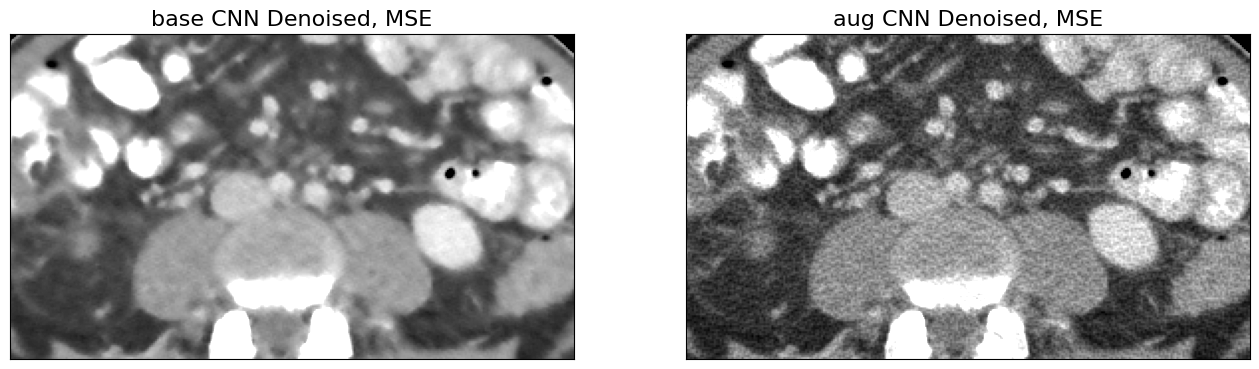

In [40]:
nexample = 2
base_CNNout = base_denoising_model.predict(test_input, batch_size=1)
aug_CNNout = aug_denoising_model.predict(test_input, batch_size=1)

plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[nexample, :, :, 0])


plt.subplot(1, 3, 2)
plt.title('base CNN Denoised Image', fontsize=16)
ctshow(base_CNNout[nexample, :, :, 0])

plt.subplot(1, 3, 3)
plt.title('aug CNN Denoised Image', fontsize=16)
ctshow(aug_CNNout[nexample, :, :, 0])

# Same as above, but with a different field of view
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(1, 2, 2)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

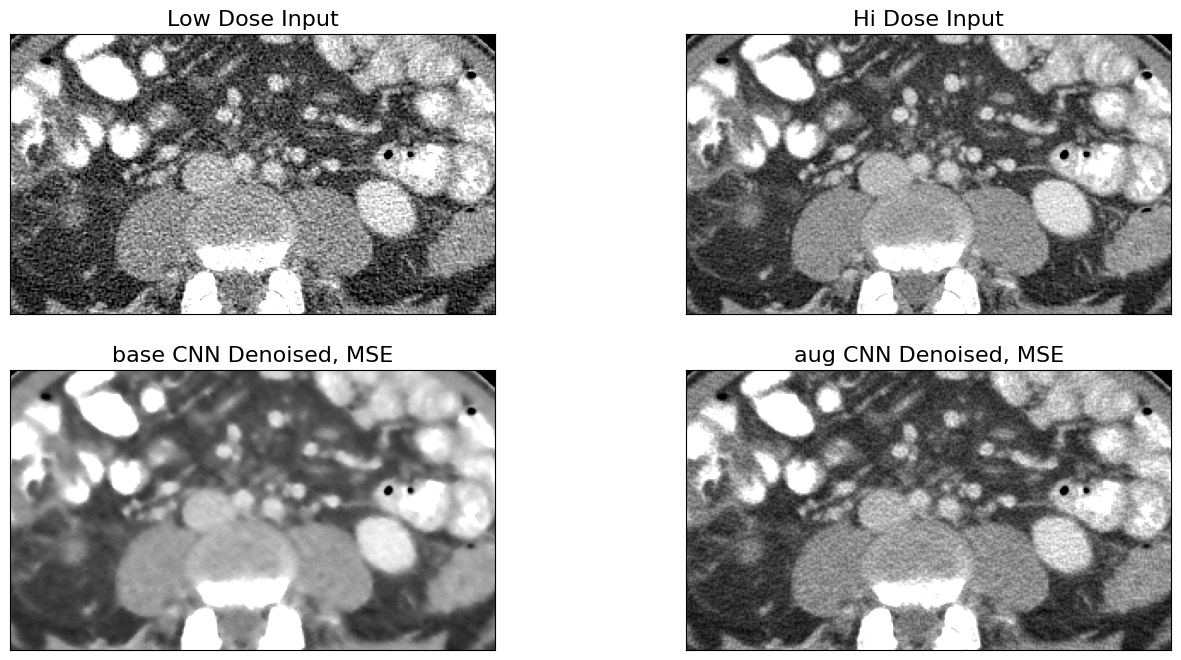

In [41]:
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title('Low Dose Input', fontsize=16)
ctshow(test_input[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 3)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 4)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])
# plt.savefig(f'comp_{aug_thresh:0.1f}.png', dpi=150)

Interesting, adding more augmentaton by lowering that threshold reduces overall denoising but improves retention of texture, see how this compares to simply adding back noise to the un-augmented cnn

So far it seems like if I add too much low frequency noise, it destroy  the training and leavee our high frequenices, so I nee to balance the weighting about how many of the traingin images have augmentation while having enough noise reduction

There's a balance between *how much* denoiosing and what frequencies to remove, so it seems like there's 2 parameters to balance

Seems like higher frequency (lower threshold) --> more augmentation and thus lower overall noise reduction, but with better texture

In [42]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

Evaluate
1/1 [==============================] - 0s 323ms/step - loss: 857.6210 - root_mean_squared_error: 29.2852


{'loss': 857.6210327148438, 'root_mean_squared_error': 29.285167694091797}

In [43]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

1/1 [==============================] - 0s 368ms/step - loss: 538.0428 - root_mean_squared_error: 23.1957


{'loss': 538.0427856445312, 'root_mean_squared_error': 23.195749282836914}

## Now Data Augmentation as a Fine Tuning Step

Take the pretrained `Simple CNN MSE` then apply the data augmentation. In theory it already knows how to denoise. Will fine tuning be destructive or improve generalizability to more textures?

In [ ]:
aug_pretrained_model, aug_pretrained_progress_ims, aug_pretrained_progress_val = train(augment_training=0.7, model=base_denoising_model, epochs=100)

1/1 [==============================] - 0s 9ms/step
Epoch 1/100
1/1 [==============================] - 0s 10ms/step
Epoch 2/100
1/1 [==============================] - 0s 9ms/step
Epoch 3/100
1/1 [==============================] - 0s 9ms/step
Epoch 4/100
1/1 [==============================] - 0s 9ms/step
Epoch 5/100
1/1 [==============================] - 0s 9ms/step
Epoch 6/100
1/1 [==============================] - 0s 9ms/step
Epoch 7/100
1/1 [==============================] - 0s 9ms/step
Epoch 8/100
1/1 [==============================] - 0s 9ms/step
Epoch 9/100
1/1 [==============================] - 0s 9ms/step
Epoch 10/100
1/1 [==============================] - 0s 9ms/step
Epoch 11/100
1/1 [==============================] - 0s 9ms/step
Epoch 12/100
1/1 [==============================] - 0s 10ms/step
Epoch 13/100
1/1 [==============================] - 0s 9ms/step
Epoch 14/100
1/1 [==============================] - 0s 9ms/step
Epoch 15/100
1/1 [==============================] - 0s 9ms/s

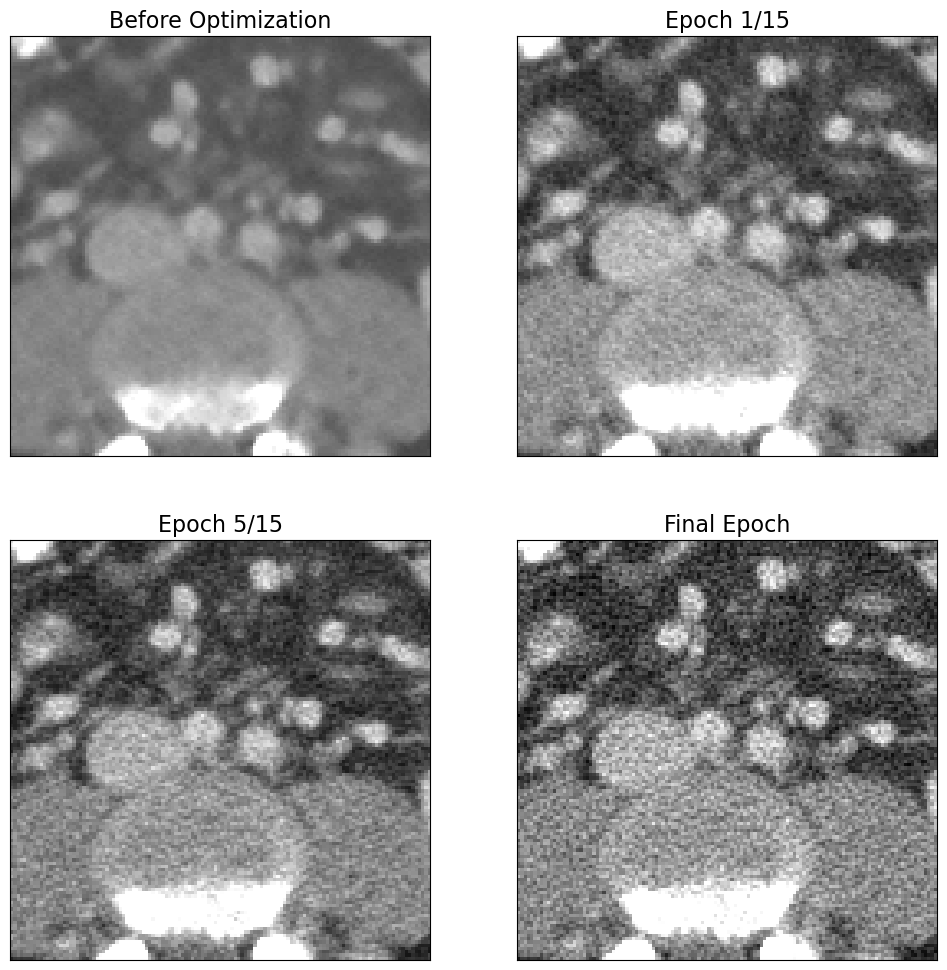

In [ ]:
check_progress_ims(aug_pretrained_progress_ims)

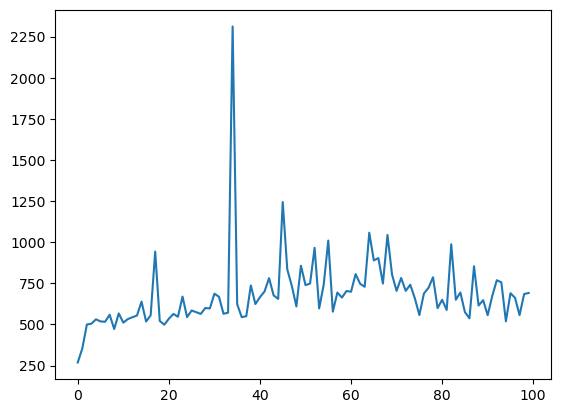

In [ ]:
plt.plot(np.array(aug_pretrained_progress_val)[:,0])

7/7 [==============================] - 0s 3ms/step


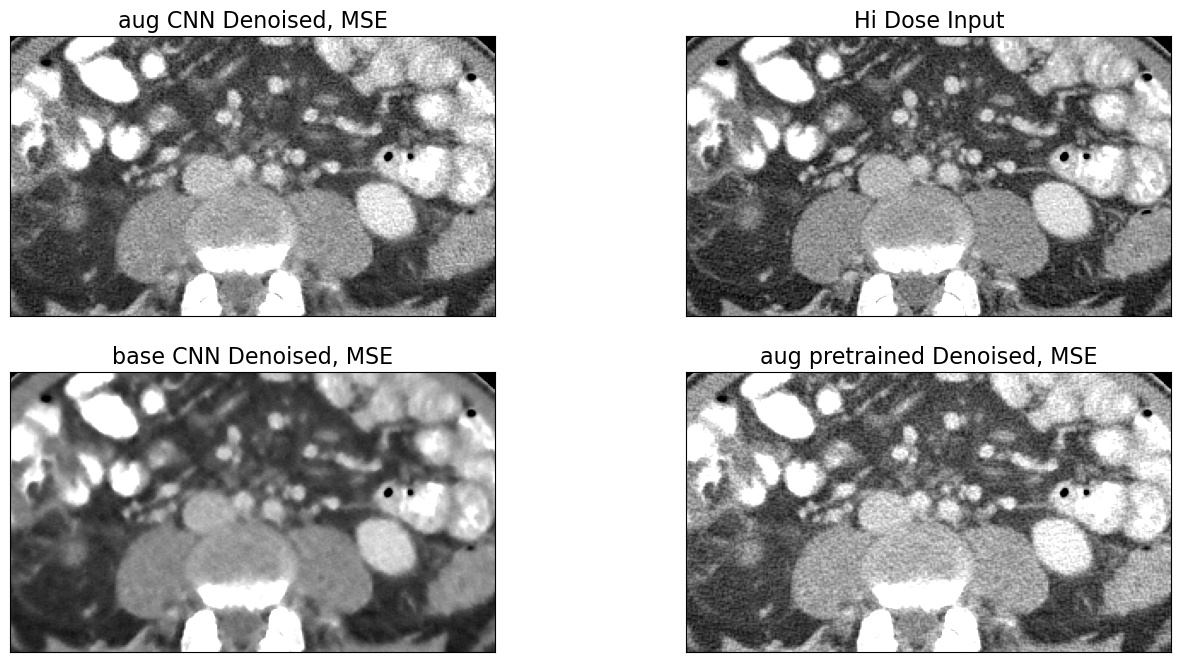

In [ ]:
aug_pretrainedout = aug_pretrained_model.predict(test_input, batch_size=1)
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title('aug CNN Denoised, MSE', fontsize=16)
ctshow(aug_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 2)
plt.title('Hi Dose Input', fontsize=16)
ctshow(test_target[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 3)
plt.title('base CNN Denoised, MSE', fontsize=16)
ctshow(base_CNNout[3, 110:-110, 50:-50, 0])

plt.subplot(2, 2, 4)
plt.title('aug pretrained Denoised, MSE', fontsize=16)
ctshow(aug_pretrainedout[3, 110:-110, 50:-50, 0])

In [ ]:
print("Evaluate")
result = base_denoising_model.evaluate(test_dataset)
dict(zip(base_denoising_model.metrics_names, result))

Evaluate
1/1 [==============================] - 0s 28ms/step - loss: 1367.9154 - root_mean_squared_error: 36.9853


{'loss': 1367.9154052734375, 'root_mean_squared_error': 36.9853401184082}

In [ ]:
result = aug_denoising_model.evaluate(test_dataset)
dict(zip(aug_denoising_model.metrics_names, result))

1/1 [==============================] - 0s 27ms/step - loss: 609.0589 - root_mean_squared_error: 24.6791


{'loss': 609.0588989257812, 'root_mean_squared_error': 24.67911720275879}

In [ ]:
result = aug_pretrained_model.evaluate(test_dataset)
dict(zip(aug_pretrained_model.metrics_names, result))

1/1 [==============================] - 0s 28ms/step - loss: 1367.9154 - root_mean_squared_error: 36.9853


{'loss': 1367.9154052734375, 'root_mean_squared_error': 36.9853401184082}

## Need to find the right balance between training loss and validation loss other  

Other quesions: how does what noises are iuncluded influence image quality and validation loss